# train the yolo
## loss: loss layer, sigmoid output all demission

In [1]:
from keras import applications, losses
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, Model, K
from keras.layers import Lambda, Input, Dropout, Flatten, Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, concatenate, GlobalAveragePooling2D, MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy
from keras.utils import Progbar, GeneratorEnqueuer
from keras.applications import imagenet_utils
import tensorflow as tf
import numpy as np
import os
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import inspect
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# libs
def mkdirp(dir):
  try:
    os.mkdir(dir)
  except:
    pass

def load_base(model):
  if model == "vgg" or model == "vgg16":
      return applications.VGG16(weights='imagenet', include_top=False),  applications.vgg16.decode_predictions, applications.vgg16.preprocess_input
  elif model == "mobilenet" or model == "mn":
      return applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), applications.mobilenet.decode_predictions, applications.mobilenet.preprocess_input
  elif model == "resnet" or model == "resnet50":
      return applications.ResNet50(weights='imagenet', include_top=False), applications.resnet50.decode_predictions, applications.resnet50.preprocess_input
  elif model == "inceptionv3" or model == "inception":
      return applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), applications.inception_v3.decode_predictions, applications.inception_v3.preprocess_input
  else:
      return None
    
def load_model(model):
  if model == "vgg" or model == "vgg16":
      return applications.VGG16(weights='imagenet'),  applications.vgg16.decode_predictions, applications.vgg16.preprocess_input
  elif model == "mobilenet" or model == "mn":
      return applications.MobileNet(weights='imagenet', input_shape=(224, 224, 3)), applications.mobilenet.decode_predictions, applications.mobilenet.preprocess_input
  elif model == "resnet" or model == "resnet50":
      return applications.ResNet50(weights='imagenet'), applications.resnet50.decode_predictions, applications.resnet50.preprocess_input
  elif model == "inceptionv3" or model == "inception":
      return applications.InceptionV3(weights='imagenet', input_shape=(224, 224, 3)), applications.inception_v3.decode_predictions, applications.inception_v3.preprocess_input
  else:
      return None

def npy_file(basedir, prefix):
  return "{}/{}.npy".format(basedir, prefix)

def npy_file_x(basedir, prefix):
  return npy_file(basedir, prefix + ".x")

def npy_file_y(basedir, prefix):
  return npy_file(basedir, prefix + ".y")


def load_feature(dir, prefix):
  feature_file = npy_file_x(dir, prefix)
  label_file = npy_file_y(dir, prefix)
  features = np.load(open(feature_file))
  labels = np.load(open(label_file))
  return features, labels

def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    filters = int(filters)
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=name + "_conv")(x)
    x = BatchNormalization(scale=False, name=name + "_bn")(x)
    x = Activation('relu', name=name)(x)
    return x 

def incept(x, name, scale=1):
    branch1x1 = conv2d_bn(x, 64 // scale, 1, 1, name = name + "-1x1")

    branch5x5 = conv2d_bn(x, 48 // scale , 1, 1, name = name + "-5x5-1x1")
    branch5x5 = conv2d_bn(branch5x5, 64 // scale, 5, 5, name = name + "-5x5-5x5")

    branch3x3dbl = conv2d_bn(x, 64 // scale, 1, 1, name = name + "-3x3-1x1")
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96 // scale, 3, 3, name = name + "-3x3-3x3-1")
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96 // scale, 3, 3, name = name + "-3x3-3x3-2")

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32 // scale, 1, 1, name = name + "-pool")
    return concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        name= name + '-all')

In [3]:
# yolo functions
JPEG_EXT = "JPEG"
def anno_file_to_rect(anno_file):
    tree = ET.parse(anno_file)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    return [(int(box.find("xmin").text), 
              int(box.find("ymin").text), 
              int(box.find("xmax").text), 
              int(box.find("ymax").text)) for box in boxes][0]

def get_image_size(af):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    return (float(image_size_el.find("width").text), float(image_size_el.find("height").text))

## return 7 x 7 * 5(C, cx, cy, hx, hy)
def anno_file_to_yolo_y(af, grid = (7 , 7)):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    image_width = float(image_size_el.find("width").text)
    image_height = float(image_size_el.find("height").text)
    cell_width = image_width / grid[0]
    cell_height = image_height / grid[1]
    
    rect = [(float(box.find("xmin").text), 
          float(box.find("ymin").text), 
          float(box.find("xmax").text), 
          float(box.find("ymax").text)) for box in boxes][0]

    width = rect[2] - rect[0]
    height = rect[3] - rect[1]
    center_x = (rect[2] + rect[0]) / 2.0
    center_y = (rect[3] + rect[1]) / 2.0
    
    # find which cell is the 1 one
    cell_idx_x = int(center_x * grid[0] / image_width)
    cell_idx_y = int(center_y * grid[1] / image_height)
    
    y1 = [1, 
          center_x / cell_width - cell_idx_x, 
          center_y / cell_height - cell_idx_y,
          width / image_width,
          height / image_height
         ]
    
    y = np.zeros((5 * grid[0] * grid[1]), dtype=np.float16)
    base = cell_idx_x  + cell_idx_y * grid[0]
    y[base * 5: (base + 1) * 5] = y1
    
    return y
  
def img2data(image_file):
  return np.array([img_to_array(load_img(image_file, target_size = (224, 224)))], dtype=np.float16)

class YoloDataGenerator(object):
    'Generates image yolo from dataset'
    def __init__(self, image_dir, annotation_dir, grid = (7,7), batch_size = 16, target_size = (224, 224)):
        'Initialization'
        self.image_dir = image_dir # image id list
        self.annotation_dir = annotation_dir
        ids = []
        for clz in os.listdir(annotation_dir):
            ids.append([clz + "/" + f for f in os.listdir(annotation_dir + "/" + clz)])
        self.ids = flatten(ids)
        self.steps = 0
        self.batch_size = batch_size
        self.target_size = target_size
        self.grid = grid

    def generate(self):
        while self.steps < len(self.ids) // self.batch_size:
            ids = self.ids[self.steps * self.batch_size: (self.steps + 1) * self.batch_size]
            image_files = [self.image_dir + "/" + id + "." + JPEG_EXT for id in ids]
            anno_files = [self.annotation_dir + "/" + id for id in ids]
            ys = [anno_file_to_yolo_y(af, self.grid) for af in anno_files]
            xs = [image.img_to_array(image.load_img(image_file,target_size =  self.target_size)) for image_file in image_files]
            self.steps += 1
            yield np.array(xs, dtype=np.float16), np.array(ys, dtype=np.float16)

In [4]:
# build the feature data
train_data_dir = './dogs/images/train'
val_data_dir = './dogs/images/val'
round = .1
nb_train_samples = NB_TRAIN_SAMPLES = int(16494 * round // 1) ## copy from split script
nb_val_samples = NB_VAL_SAMPLES = int(4086 * round //1) ## copy from split script
epochs = 50
batch_size = 16
n_classes = 120
img_width, img_height = 224, 224

base_model_name = "inception"
GRIDS = {"inception": (5,5)}
grid = GRIDS[base_model_name]

mkdirp(base_model_name)

In [5]:
images_root = "/Users/xuan/work/dataset/dogs/images"
annotations_root = "/Users/xuan/work/dataset/dogs/annotations"
train_images_root = images_root + "/train"
val_images_root = images_root + "/val"
train_annotations_root = annotations_root + "/train"
val_annotations_root = annotations_root + "/val"

In [6]:
# 加载feature数据到内存
val_features, val_labels = load_feature(base_model_name, "val-dogs-120")
print "shapes for val feature",val_features.shape, val_labels.shape

train_features, train_labels = load_feature(base_model_name, "train-dogs-120")
print "shapes for train feature ", train_features.shape, train_labels.shape

shapes for val feature (400, 5, 5, 2048) (400, 125)
shapes for train feature  (1648, 5, 5, 2048) (1648, 125)


In [259]:
def yolo_loss(y_, y, confidence_loss_weight = 1.0, location_loss_weight = 1.0, noobj_loss_weight = 1.0, grid = (5,5)):
  # reshape to split into boxes
  y_ = K.reshape(y_, [-1, grid[0] * grid[1], 5])
  y = K.reshape(y, [-1,  grid[0] * grid[1], 5])

  objects_matcher = y[..., 0:1]
  objects_boxes_coord = y[..., 1:3] * objects_matcher
  objects_boxes_coord_ = y_[..., 1:3] * objects_matcher
  boxes_loss = K.sum(K.square(objects_boxes_coord - objects_boxes_coord_))

  objects_boxes_size = y[..., 3:5] * objects_matcher
  objects_boxes_size_ = y_[..., 3:5] * objects_matcher
  boxes_loss += K.sum(K.abs((objects_boxes_size) - (objects_boxes_size_)))

  objects_confidences = y[..., 0:1]
  objects_confidences_ = y_[..., 0:1] * objects_confidences
  object_confidence_loss = K.sum(K.square(objects_confidences - objects_confidences_))

  non_objects_confidences_ = y_[..., 0:1] * (1.0 - y[..., 0:1])
  non_object_confidence_loss = K.sum(K.square(non_objects_confidences_))
  
  return boxes_loss * location_loss_weight + object_confidence_loss * confidence_loss_weight + non_object_confidence_loss * noobj_loss_weight

In [8]:
def simple_loss(args):
    (y_, y) = args
    objects_matcher = y[..., 0:1]
    objects_boxes = y[..., 1:5] * objects_matcher
    objects_boxes_ = y_[..., 1:5] * objects_matcher
    boxes_loss = K.sum(K.square(objects_boxes - objects_boxes_))
#     y_ = K.reshape(y_, [y_.shape[0], -1, 5])
#     y = K.reshape(y, [y_.shape[0], -1, 5])
    return boxes_loss

In [260]:
# build the yolo regression model
feature_input = Input(shape=(5,5,2048), name = 'feature_input')
x = feature_input
batch_size = 32
n_outputs = grid[0] * grid[1] * 5

x = Flatten()(x)
# x = Dropout(0.8)(x)
# x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.8)(x)
x = Dense(n_outputs, activation='sigmoid', name='predictions')(x)

boxes_input = Input(shape=(125,), name = "box_input")

model = Model(input = feature_input, output = x)

def the_yolo_loss(args):
    (y_, y) = args
    return yolo_loss(y_, y, confidence_loss_weight = 1.0, location_loss_weight = 5.0, noobj_loss_weight = 0.5, grid = grid)

model_loss_layer = Lambda(
            the_yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={})([x, boxes_input])

full_model = Model(input = [feature_input, boxes_input], output=model_loss_layer)

full_model.compile(loss={
                    'yolo_loss': lambda y_true, y_pred: y_pred
                },
              optimizer=optimizers.Adadelta())

full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 5, 5, 2048)   0                                            
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 51200)        0           feature_input[0][0]              
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 51200)        0           flatten_15[0][0]                 
__________________________________________________________________________________________________
predictions (Dense)             (None, 125)          6400125     dropout_15[0][0]                 
__________________________________________________________________________________________________
box_input 

/Library/Python/2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("fe...)`
  from ipykernel import kernelapp as app
/Library/Python/2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("yo..., inputs=[<tf.Tenso...)`


In [261]:
# train
total_params = "6400125"
id = "yolo-dogs-" + base_model_name + "-" + total_params
weights = base_model_name + "/" + id + ".h5"
print "weights", weights

if os.path.exists(weights):
  pass

full_model.fit([train_features,train_labels], np.zeros(len(train_labels)),
          shuffle = True,
          epochs=50,
          batch_size=32,
          validation_data=([val_features, val_labels], np.zeros(len(val_labels)))
         )

weights inception/yolo-dogs-inception-6400125.h5
Train on 1648 samples, validate on 400 samples
Epoch 1/50
1648/1648 [==============================] - 8s 5ms/step - loss: 162.7270 - val_loss: 136.8973
Epoch 2/50
1648/1648 [==============================] - 5s 3ms/step - loss: 149.3850 - val_loss: 124.8829
Epoch 3/50
1648/1648 [==============================] - 5s 3ms/step - loss: 144.7919 - val_loss: 121.3804
Epoch 4/50
1648/1648 [==============================] - 5s 3ms/step - loss: 139.8834 - val_loss: 130.8999
Epoch 5/50
1648/1648 [==============================] - 5s 3ms/step - loss: 136.2751 - val_loss: 125.1507
Epoch 6/50
1648/1648 [==============================] - 5s 3ms/step - loss: 135.0913 - val_loss: 119.9185
Epoch 7/50
1648/1648 [==============================] - 5s 3ms/step - loss: 133.0846 - val_loss: 116.7479
Epoch 8/50
1648/1648 [==============================] - 5s 3ms/step - loss: 131.2038 - val_loss: 128.6061
Epoch 9/50
1648/1648 [==============================] - 

In [155]:
mkdirp(base_model_name)
base_model, base_decoder, processor = load_base(base_model_name)
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [262]:
# build full model
input = Input(shape=(img_width, img_height, 3), name = 'feature_input')
x = base_model(input)
x = model(x)
completed_model = Model(input=input, output=x)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("fe...)`
  """


In [146]:
def create_random_model(base_model):
  input = Input(shape=(img_width, img_height, 3), name = 'feature_input')
  x = base_model(input)
  x = Flatten()(x)
  x = Dense(4, activation='sigmoid', name='predictions')(x)
  return Model(input=input, output=x)

In [147]:
random_model = create_random_model(base_model)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("fe...)`
  


In [215]:
flatten = lambda l: [item for sublist in l for item in sublist]

train_generator = YoloDataGenerator(train_images_root, train_annotations_root)
val_generator = YoloDataGenerator(val_images_root, val_annotations_root)

In [315]:
def eval(completed_model = completed_model, val = True):
  batch_size = 4
  _, axs = plt.subplots(1, batch_size, figsize=(32, 32))
  for i in range(0, batch_size):
      ax = axs[i]
      ax.grid(b=None)
    
      total = len(val_generator.ids) if val else  len(train_generator.ids)
      sample = np.random.randint(0, total) if val else np.random.randint(0, total)
      generator = val_generator if val else train_generator
      image_file =  "{}/{}/{}.{}".format(images_root, "val" if val else "train", generator.ids[sample], JPEG_EXT)
      annotation_file = "{}/{}/{}".format(annotations_root ,"val" if val else "train", generator.ids[sample])

      (image_width, image_height) = get_image_size(annotation_file)

      ax.imshow(imread(image_file))

      rect = anno_file_to_rect(annotation_file)
      patch = patches.Rectangle((rect[0],rect[1]),rect[2] - rect[0],rect[3] - rect[1],linewidth=4,edgecolor='g',facecolor='none')
      ax.add_patch(patch)
      print "truth rect", rect

      # draw fitted model
      xs = img2data(image_file)
      # predict
      y_ = completed_model.predict(processor(xs), batch_size = 1)
      y_ = y_[0]
      cell = np.argmax(np.hstack(np.array([[1,0,0,0,0]] * (grid[0] * grid[1]))) * y_) / 5 
      print "confidences list as\n", np.round(100.0 * np.reshape(y_, (-1, 5, 5, 5))[..., 0]) / 100.0
      cell_x = cell % grid[1]
      cell_y = cell // grid[0]
      base = cell * 5
      gx = grid[0]
      gy = grid[1]
      cell_width = float(image_width) / gx
      cell_height = float(image_height) / gy

      (C, cx, cy, w, h) = y_[base: base + 5]
#       print "Max Confidence cx, cy, w, h", y_[base: base + 5]

      rect = np.array([(cell_x + cx - w * gx / 2.0 ) * cell_width, 
                (cell_y + cy - h * gy / 2.0 ) * cell_height, 
                w * image_width, 
                h * image_height])
#       print "rect", (rect[0], rect[1]), rect[2], rect[3]

      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
      ax.add_patch(patch)
      center_x = (cell_x + cx) * cell_width
      center_y = (cell_y + cy) * cell_height

      # print center point
#       print "center x & y", center_x, center_y
      patch = patches.Circle((center_x, center_y), 6, linewidth=1,color='r',fill='full')
      ax.add_patch(patch)

      #draw center rect
      rect = (cell_x * cell_width, cell_y * cell_height, cell_width, cell_height)
      print "center cell", rect
      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
#       ax.add_patch(patch)
  
  plt.show()

eval some train data
truth rect (58, 205, 373, 498)


/Library/Python/2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


confidences list as
[[[ 0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.56  0.    0.    0.  ]
  [ 0.    0.01  0.01  0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]]]
center cell (75.0, 200.0, 75.0, 100.0)
truth rect (103, 177, 264, 337)
confidences list as
[[[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]
center cell (133.19999999999999, 200.0, 66.6, 100.0)
truth rect (22, 67, 416, 369)
confidences list as
[[[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]
center cell (200.0, 156.80000000000001, 100.0, 78.4)
truth rect (191, 17, 382, 332)
confidences list as
[[[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.41999999  0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.    

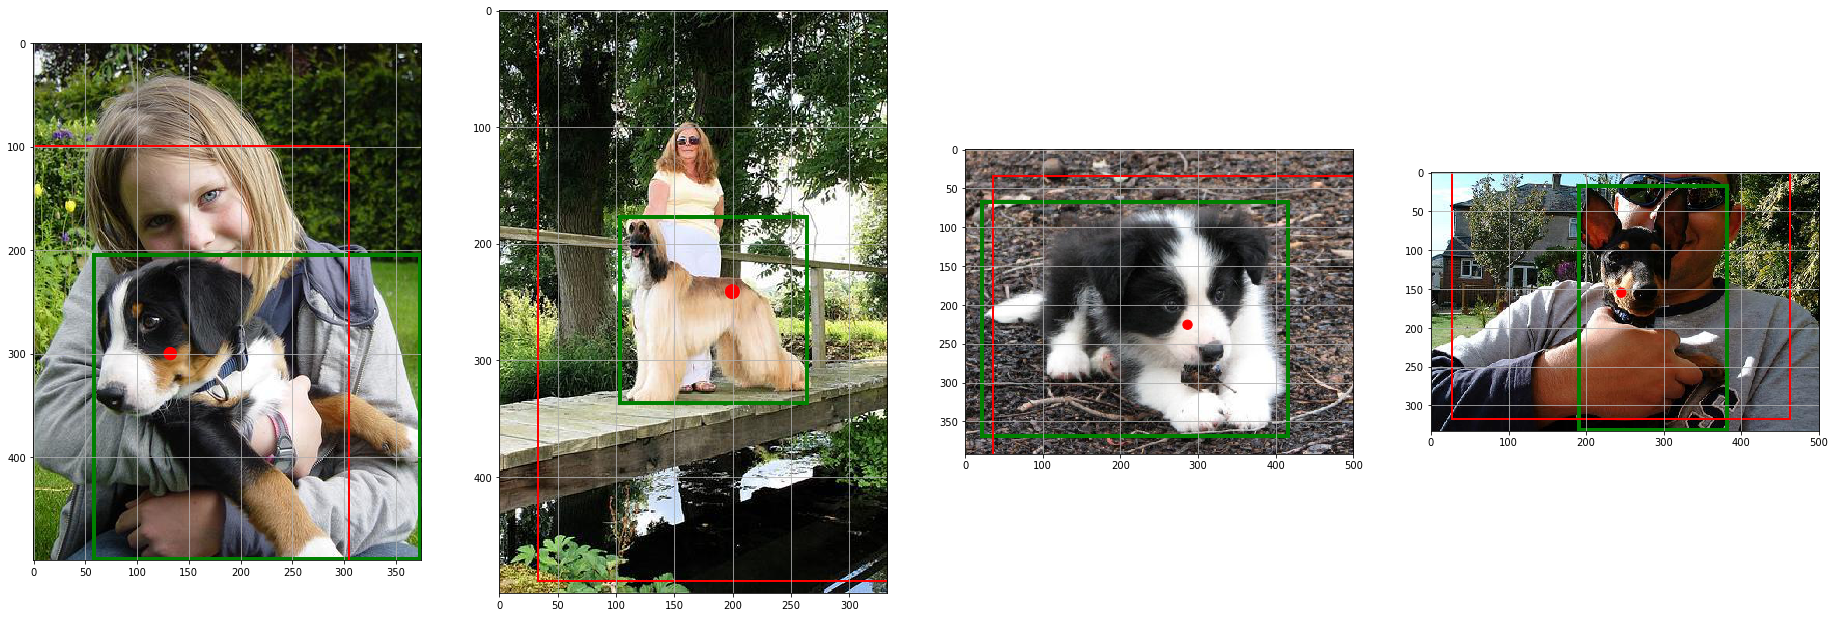

In [324]:
print "eval some train data"
eval(val=False)